In [1]:
from __future__ import division

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from math import sqrt

In [3]:
pi = np.pi
twopi = 2*pi

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc

In [5]:
import helpy

In [6]:
import tracks, otracks
import orientation as orient
import correlation as corr

In [7]:
S = 17.5
fps = 120
freq = 50

In [8]:
rc('font', family='serif', serif=['Latin Modern', 'Computer Modern'])
rc('text', usetex=True)
smallfig = (5,4)
largefig = (8,6)

In [9]:
locdir = '/Users/leewalsh/Physics/Squares/Noise/Walker/'

In [10]:
dataset_names = ['n8_100mv_50hz_{}'.format(i) for i in range(1,5)] + ['n2_pAB_1', 'n2_pAB_2', 'n2_pBC']

In [12]:
def loadall(prefix):
    data, trackids, odata, omask = helpy.load_data(locdir+prefix, ret_odata=True, ret_cdata=False)
    fsets = helpy.splitter(data, ret_dict=True)
    fosets = helpy.splitter(odata[omask], data['f'], ret_dict=True)
    longtracks = np.argwhere(np.bincount(trackids) > 1000).flatten()
    tracksets  = { track:  data[(data['lab']==track)&omask]
                   for track in longtracks}
    otracksets = { track: orient.track_orient(odata[(data['lab']==track)&omask]['orient'], onetrack=True)
                   for track in longtracks}
    msds, msdids, msads, msadids, dtau, dt0 = helpy.load_MSD(locdir+prefix, True, True)
    return data, tracksets, odata, otracksets, msds, msdids, msads, msadids, dtau, dt0

In [251]:
[len(tracksets[track]) for track in longtracks]

[7535, 7710, 7722, 7709, 7708, 7676, 7692, 7660]

using dtau = 10, dt0 = 10
using S = 20 pixels, thus A = 400 px^2


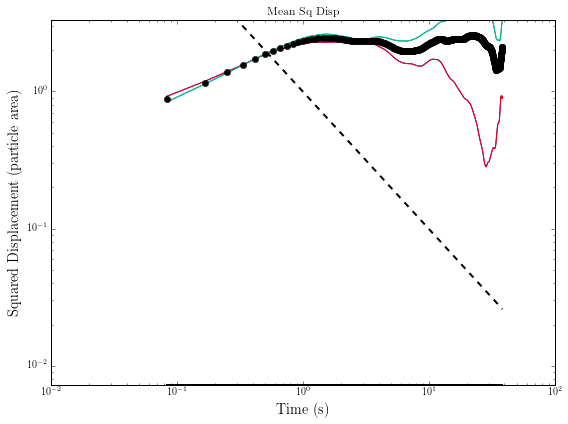

In [241]:
tracks.plot_msd(msds, msdids, dtau, dt0, nframes=len(fsets), tnormalize=1,
                fps=fps, S=S, #approx...
                figsize=largefig,
                #ylim=((msds[...,1]/msds[...,0]).min(),(msds[...,1]/msds[...,0]).max())
               )

using dtau = 10, dt0 = 10
using S = 20 pixels, thus A = 1 px^2


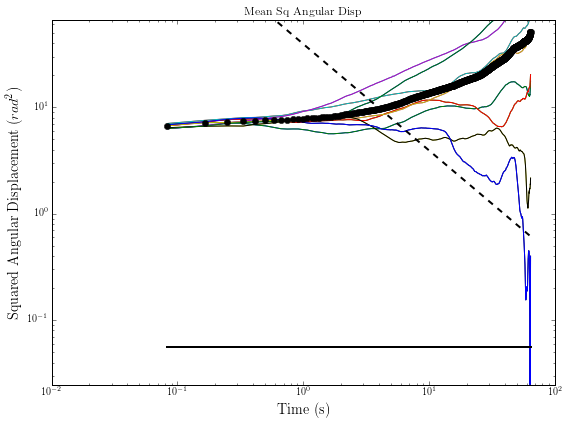

In [182]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframes=len(fsets), ang=True, tnormalize=1,
                fps=fps, S=S, figsize=largefig)

In [186]:
rot_step = np.mean([np.abs(np.diff(odata[(data['lab']==track)&omask]['orient'])).mean()
                                          for track in longtracks])
print rot_step/pi, "* pi"

0.0729709440103 * pi


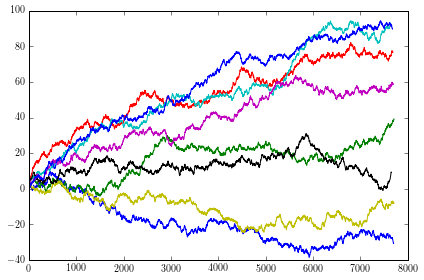

In [187]:
for track in longtracks:
    plt.plot(otracksets[track])

In [13]:
# Build up data dicts by track for all datasets
alltracksets = {}
allotracksets = {}
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    data, tracksets, odata, otracksets, msds, msdids, msads, msadids, dtau, dt0 = loadall(prefix)
    alltracksets[prefix] = tracksets
    allotracksets[prefix] = otracksets

n8_100mv_50hz_1
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_1
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_1
n8_100mv_50hz_2
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_2
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_2
n8_100mv_50hz_3
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_3
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_3
n8_100mv_50hz_4
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_4
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_4


In [14]:
# Calculate all <nn> correlations
# That is, <cos(phi) cos(phi)> and <sin(phi) sin(phi)>
allocoscorr = {} # this is <n_i n_i>, the ii component of <nn>
allosincorr = {} # and <n_j n_j>, the jj component of <nn>
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    otracksets = allotracksets[prefix]
    allocoscorr[prefix] = {track: corr.autocorr(np.cos(otrackset)) for track, otrackset in otracksets.items()}
    allosincorr[prefix] = {track: corr.autocorr(np.sin(otrackset)) for track, otrackset in otracksets.items()}

n8_100mv_50hz_1
n8_100mv_50hz_2
n8_100mv_50hz_3
n8_100mv_50hz_4


[ 12.91188958]
  D_R: 0.077
1/D_R: 12.912


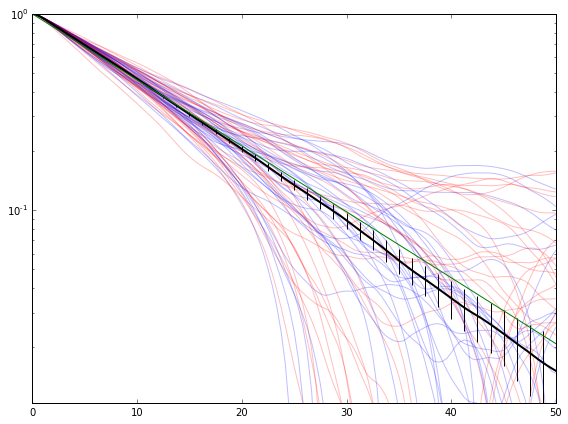

In [223]:
# Average, Fit and plot <nn> correlation
plt.figure(figsize=largefig)

allcorr = []
nframes = 2000
tcorr = np.arange(nframes)*freq/fps
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    normed = prefix.endswith('1') or prefix.endswith('2')
    color = 'b' if normed else 'r'
    for track in allotracksets[prefix]:
        coscorr = allocoscorr[prefix][track][:nframes]
        sincorr = allosincorr[prefix][track][:nframes]
        allcorr.append(coscorr)
        allcorr.append(sincorr)
        plt.semilogy(tcorr, coscorr, 'b', alpha=.25)
        plt.semilogy(tcorr, sincorr, 'r', alpha=.25)
allcorr = np.asarray(allcorr)
meancorr = np.mean(allcorr, 0)
errcorr = np.std(allcorr, 0)/sqrt(len(allcorr))
err_offset = errcorr.mean()
tmax = 50

plt.errorbar(tcorr, meancorr, errcorr, None, 'k',capthick=0, lw=2, elinewidth=1, errorevery=3)
plt.xlim(0, tmax)
fmax = np.searchsorted(tcorr, tmax)
popt, pcov = curve_fit(corr.exp_decay, tcorr[:fmax], meancorr[:fmax],
                       p0=[10], sigma=err_offset + errcorr[:fmax])
print popt
D_R = 1/popt[0]
print "  D_R: {:.3f}\n1/D_R: {:.3f}".format(D_R, 1/D_R)
plt.semilogy(tcorr, corr.exp_decay(tcorr, *popt), 'g')
#plt.yscale('linear')
plt.ylim(corr.exp_decay(tmax, *popt)/2, 1)
plt.legend()

In [287]:
reload(corr)

<module 'correlation' from 'correlation.py'>

In [296]:
print '\n'.join(alloxcorr.keys())

normalize: False, reverse: False, cumulant: True, ret_dx: True, side: left, verbose: False
normalize: False, reverse: False, cumulant: True, ret_dx: True, side: right, verbose: False
normalize: False, reverse: False, cumulant: True, ret_dx: True, side: both, verbose: False
normalize: False, reverse: False, cumulant: True, mode: full, ret_dx: True, side: right, verbose: False
normalize: False, reverse: False, cumulant: True, dontavg: True, ret_dx: True, side: right, verbose: False


In [311]:
# Calculate all <rn> correlations
# That is, <x cos(phi)> and <y sin(phi)>
#alloxcorr = {}
#alloycorr = {}
corr_args = {'side': 'both', 'cumulant': True, 'normalize': False, 'verbose': False,
             'reverse': False, 'ret_dx': True}
#zero_by = '0' #r0 #mean

#zeros = {'0':    lambda arr: 0,
#         'mean': lambda arr: arr.mean()
#         'r0':   lambda arr: arr[0]}
#zero =  zeros[zero_by]
setup = ', '.join(["{}: {}".format(k,v) for k,v in corr_args.iteritems()])
                #'normed,'*corr_args['normalize'],
                 #'-' + zero_by + ',',
                 #',shift'*corr_args['shift'],
                 #corr_args['side'],
                 #',ycosxsin',
                 #',reverse'*corr_args['reverse']
                 #])
print 'setup:', setup
alloxcorr[setup] = {}
alloycorr[setup] = {}
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    tracksets = alltracksets[prefix]
    otracksets = allotracksets[prefix]
    alloxcorr[setup][prefix] = {track: corr.crosscorr(tracksets[track]['x']/S,
                                               np.cos(otracksets[track]), **corr_args)
                         for track in tracksets.keys()}
    alloycorr[setup][prefix] = {track: corr.crosscorr(tracksets[track]['y']/S,
                                               np.sin(otracksets[track]), **corr_args)
                         for track in tracksets.keys()}
print '\n'.join(alloxcorr.keys())

setup: normalize: False, reverse: False, cumulant: True, ret_dx: True, side: both, verbose: False
n8_100mv_50hz_1
n8_100mv_50hz_2
n8_100mv_50hz_3
n8_100mv_50hz_4
normalize: False, reverse: False, cumulant: True, ret_dx: True, side: left, verbose: False
normalize: False, reverse: False, cumulant: True, ret_dx: True, side: right, verbose: False
normalize: False, reverse: False, cumulant: True, ret_dx: True, side: both, verbose: False
normalize: False, reverse: False, cumulant: True, mode: full, ret_dx: True, side: right, verbose: False
normalize: False, reverse: False, cumulant: True, dontavg: True, ret_dx: True, side: right, verbose: False


normalize: False, reverse: False, cumulant: True, ret_dx: True, side: left, verbose: False
trange -8 0
time -832.916666667 0.0
xlim (-8, 0)
frames, 1980 1999
shape (2000,)
fit not found, using p0
v0/D_R: 1.0000
   D_R: 0.0774
normalize: False, reverse: False, cumulant: True, ret_dx: True, side: right, verbose: False
trange 0 200
time 0.0 832.916666667
xlim (0, 200)
frames, 0 480
shape (2000,)
v0/D_R: 0.3800
   D_R: 0.1596
normalize: False, reverse: False, cumulant: True, ret_dx: True, side: both, verbose: False
trange -8 200
time -832.916666667 832.916666667
xlim (-8, 200)
frames, 1980 2479
shape (3999,)
v0/D_R: 0.3809
   D_R: 0.1061


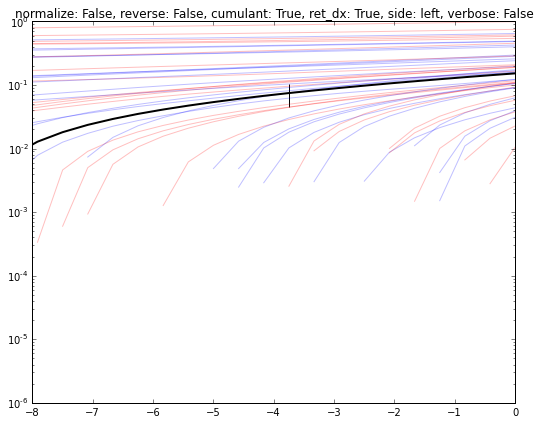

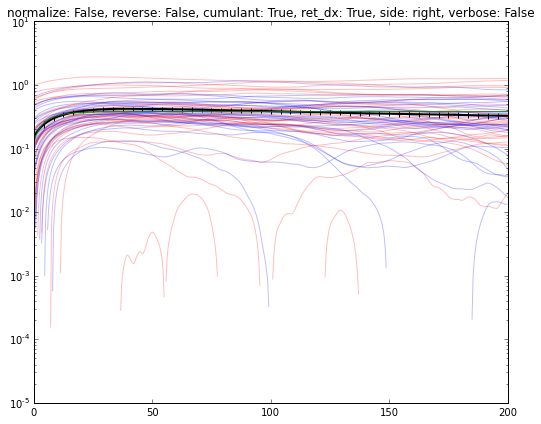

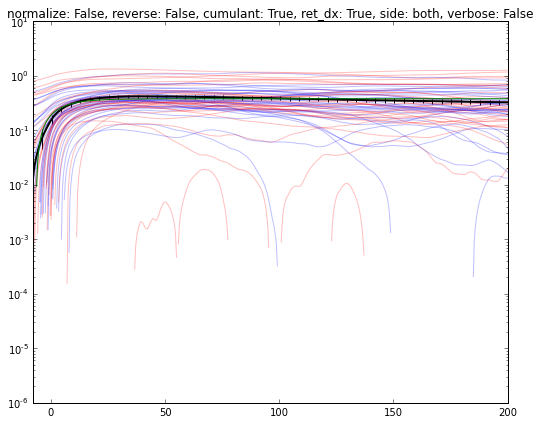

In [313]:
# Average, Fit and plot <rn> correlation
do_fit = True
rc('text', usetex=False)
for setup in alloxcorr.keys():
    if 'mode' in setup: continue
    if 'dontavg' in setup: continue
    print setup
    ret_dx = 'ret_dx: True' in setup
    plt.figure(figsize=largefig)
    plt.title(setup)
    allcorr = []
    nframes = 2000
    tcorr = np.arange(nframes)*freq/fps
    for prefix in dataset_names:
        if 'n8' not in prefix: continue
        for track in allotracksets[prefix]:
            if ret_dx:
                tcorr = alloxcorr[setup][prefix][track][0]
                index = np.abs(tcorr) < nframes
                oxcorr = alloxcorr[setup][prefix][track][1][index]
                oycorr = alloycorr[setup][prefix][track][1][index]
                tcorr = tcorr[index]*freq/fps
                if False:#'left' in setup:
                    tcorr = tcorr[::-1]
                    oycorr = oycorr[::-1]
                    oxcorr = oxcorr[::-1]
            else:
                oxcorr = alloxcorr[setup][prefix][track][:nframes]
                oycorr = alloycorr[setup][prefix][track][:nframes]
            #oxcorr -= oxcorr.min()
            #oycorr -= oycorr.min()
            #oxcorr /= oxcorr[0]+1e-4
            #oycorr /= oycorr[0]+1e-4
            allcorr.append(oxcorr)
            allcorr.append(oycorr)
            plt.semilogy(tcorr, oxcorr, 'b', alpha=.25)
            plt.semilogy(tcorr, oycorr, 'r', alpha=.25)
    allcorr = np.asarray(allcorr)
    meancorr = np.nanmean(allcorr, 0)
    errcorr = np.nanstd(allcorr, 0)/sqrt(len(allcorr))
    err_offset = np.abs(errcorr.mean())
    tmin, tmax = 0 if 'right' in setup else -8, 0 if 'left' in setup else 200
    print 'trange', tmin, tmax
    plt.errorbar(tcorr, meancorr, errcorr, None, 'k',capthick=0, lw=2, elinewidth=1, errorevery=10)
    xlims = max(tmin, tcorr.min()), min(tmax, tcorr.max())
    print 'time', tcorr.min(), tcorr.max()
    print 'xlim',xlims
    plt.xlim(*xlims)
    #plt.ylim(1e-2, 2)
    
    if do_fit:
        #print np.column_stack([tcorr,meancorr])
        fmax = np.searchsorted(tcorr, tmax)
        fmin = np.searchsorted(tcorr, tmin)
        print 'frames,',fmin, fmax
        print 'shape',meancorr.shape
        #print meancorr[fmin:fmax]
        fitform = lambda s, a, D=D_R, dx0=0: a*(1 - corr.exp_decay(s-dx0, 1/D))
        p0 = [1.0, D_R, 0]
        try:
            popt, pcov = curve_fit(fitform, tcorr[fmin:fmax], meancorr[fmin:fmax],
                               p0=p0, sigma=err_offset + errcorr[fmin:fmax]
                               )
        except RuntimeError:
            print "fit not found, using p0"
            popt = p0
        print '\n'.join(['v0/D_R: {:.4f}', '   D_R: {:.4f}'][:len(popt)]).format(*popt)
        fit = fitform(tcorr, *popt)
        plt.semilogy(tcorr, fit, 'g')
    #plt.yscale('linear')
    #plt.ylim(fit_func(tmax, *popt)/2, 1)
    #plt.legend()

    if False:
        plt.figure(figsize=largefig)
        for icorr in allcorr:
            plt.semilogy(tcorr, popt[1] - icorr, 'r', alpha=.25)
            plt.semilogy(tcorr, fit[fmax] - fit, 'k', lw=1)
        plt.xlim(0, tmax)
        plt.ylim(1e-2, 1e2)

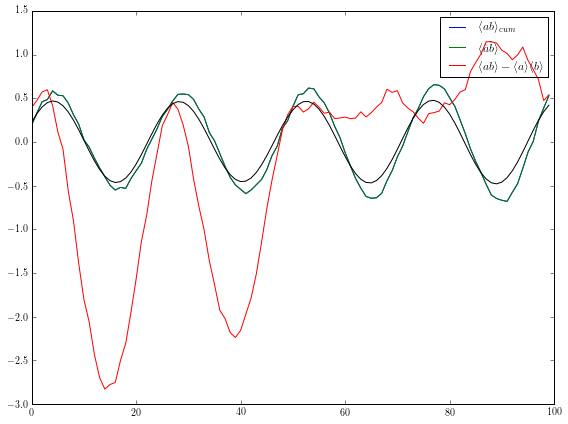

In [192]:
L = 100
x = np.linspace(0, 2*pi, L)
a = np.sin(x*4) + 2*np.random.rand(L) + 9
b = np.sin(x*4.2) + np.random.rand(L) - 7
side = 'both'
acs = {r"$\langle a(t) b(t+s)\rangle_{cum}$":
            corr.crosscorr(a, b, cumulant=True, side=side),
        r"$\langle ab\rangle - \langle a\rangle\langle b\rangle$":
            corr.crosscorr(a, b, side=side) - a.mean()*b.mean(),
        r"$\langle a(t)b(t+s)\rangle - \langle a b\rangle$":
            corr.crosscorr(a, b, side=side) - np.dot(a,b),
        r"$\langle \hat a \hat b \rangle$":
            corr.crosscorr(a-a.mean(), b-b.mean(), side=side)
        }
AC = corr.crosscorr(np.sin(x*4), np.sin(x*4.2), side=side)
#keys, vals = zip(*acs.items())
#acstack = np.row_stack(vals)
#print ", ".join(keys)
#print acstack[:,:3]

plt.figure(figsize=largefig)
for name, ac in acs.iteritems():
    plt.plot(ac, label=name)
plt.plot(AC, 'k')
plt.legend()

In [151]:
%timeit corr.crosscorr(a, b, cumulant=True),
%timeit corr.crosscorr(a, b, cumulant=(False, True)),
%timeit corr.crosscorr(a, b, cumulant=(True, False)),
#%timeit corr.crosscorr(a, b, shift=True),
%timeit corr.crosscorr(a-a.mean(), b-b.mean())

1 loops, best of 3: 943 ms per loop
1 loops, best of 3: 940 ms per loop
1 loops, best of 3: 926 ms per loop
1 loops, best of 3: 947 ms per loop


In [186]:
a.mean(), b.mean()

(10.016626122430456, 7.5432179183153139)

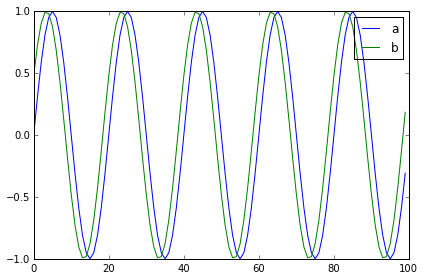

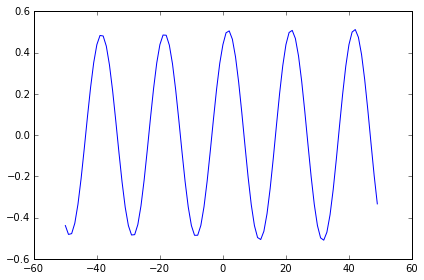

In [242]:
L = 100
source = np.random.rand(L)
x = np.arange(L)
a = source[10:]  # happens sooner
b = source[:-10] # predicted by `a`
a = np.sin(x*2*pi/20)
b = np.sin(x*2*pi/20 + 1/2)
# if we correlate <a(x) b(x + dx)> we should have a peak at dx = +10
dx, cc = corr.crosscorr(a, b, ret_dx=True)
plt.plot(a, label='a')
plt.plot(b, label='b')
plt.legend()
plt.figure()
plt.plot(dx, cc)